In [1]:
import numpy as np
import torch.nn as nn
import torch
import torchvision

import matplotlib.pyplot as plt
from IPython import display
import torch.nn.functional as F
from copy import deepcopy
from torch.utils.data import DataLoader

from utils import tensor_list_prod, make_random_affine_dependency_dataset
from models import linearNN, linearNN_with_activation, linearNN_dropout
from utils import NoisyDataset

device = 'cpu'

In [2]:
def validate(loss_history, rank_history, verbose_interval):
        axis = range(0, verbose_interval * len(loss_history), verbose_interval)
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.plot(axis, loss_history)
        ax1.set_title('Loss')
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('$||\hat{y} - y||_2$')
        ax2.plot(axis, rank_history)
        ax2.set_title('Rank evolution')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('rank')
        plt.show()

def train_nn(net, opt, loader, criterion, 
             with_noise=False, sigma_noise=0.1,
             num_epochs=500, verbose_interval=50, tol=1e-3):
    
    loss_history = []
    rank_history = []
    for epoch in range(num_epochs):
        for (batch, answer) in loader:
            opt.zero_grad()
            pred = net.to(device).forward(batch.to(device))
            loss = criterion(pred, answer.to(device))
            loss.backward()
            if with_noise: 
                for param in net.parameters():
                    param.grad += torch.randn_like(param.grad) * sigma_noise
            opt.step()    
        
        
        if epoch % verbose_interval == 0:
            rank = torch.matrix_rank(tensor_list_prod(list(net.parameters())))
            rank_history.append(rank)
            loss_history.append(loss.item())
            display.clear_output(wait=True)
            print('Epoch:', epoch)
            validate(loss_history, rank_history, verbose_interval)
            
        if loss_history[-1] < tol:
            print('Early stop activated!')
            break
    return loss_history, rank_history

Now, let's consider $X$ to have `1000` dimensions, $Y$ to have `250` dimensions and $1000$ data points

In [23]:
torch.manual_seed(42)
np.random.seed(42)
num_points=1000 
x_size=1000
y_size=250

data, R = make_random_affine_dependency_dataset(num_points, x_size, y_size, device=device)
net = linearNN(x_size, y_size, widths=[250,], init=10).to(device)

Now, let's consider the `GD` training without noise

In [4]:
net_gd = deepcopy(net)
opt = torch.optim.SGD(net_gd.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loader = DataLoader(data, batch_size=num_points, drop_last=False)

Epoch: 2950


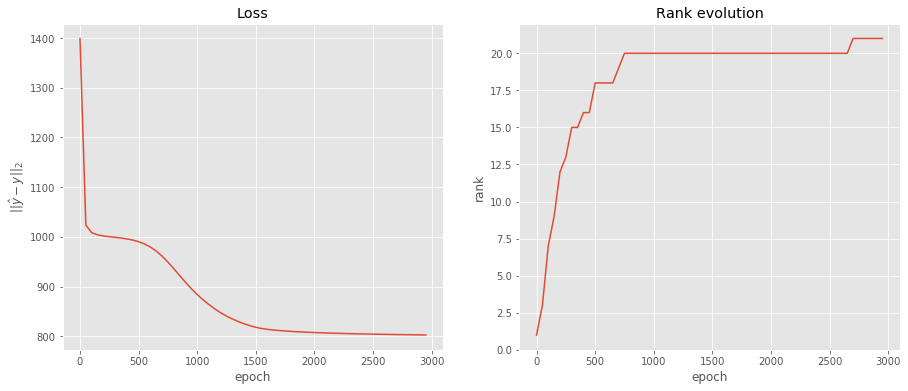

In [5]:
loss_hist_gd, rank_hist_gd = train_nn(net_gd, opt, loader, criterion, num_epochs=3000, with_noise=False, sigma_noise=20.)

Now, let's consider `GD` training with noise

In [6]:
net_gd_ns = deepcopy(net)
opt = torch.optim.SGD(net_gd_ns.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loader = DataLoader(data, batch_size=num_points, drop_last=False)

Epoch: 2950


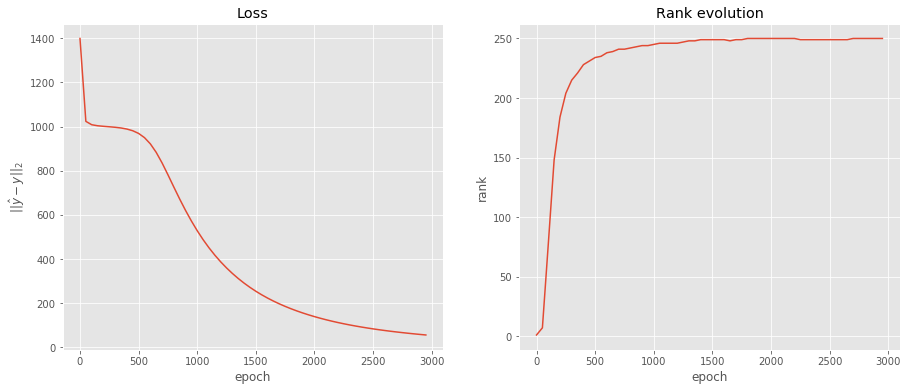

In [7]:
loss_hist_gd_ns, rank_hist_gd_ns = train_nn(net_gd_ns, opt, loader, criterion, num_epochs=3000, with_noise=True, sigma_noise=0.04)

Let's consider $X$ with noise

In [11]:
net_x = deepcopy(net)
opt = torch.optim.SGD(net_x.parameters(), lr=1e-2)
data_x = NoisyDataset('x', data, 0.1)
# data_x = data
criterion = nn.MSELoss()
loader = DataLoader(data_x, batch_size=num_points, drop_last=False)

Epoch: 2950


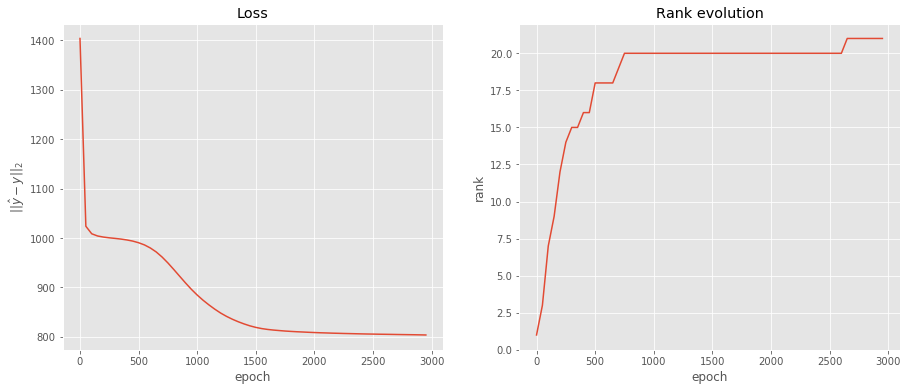

In [12]:
loss_hist_x, rank_hist_x = train_nn(net_x, opt, loader, criterion, num_epochs=3000, with_noise=False, sigma_noise=20.)

Let's consider $Y$ with noise

In [24]:
net_y = deepcopy(net)
opt = torch.optim.SGD(net_y.parameters(), lr=1e-2)
data_y = NoisyDataset('y', data, 0.1)
criterion = nn.MSELoss()
loader = DataLoader(data_y, batch_size=num_points, drop_last=False)

Epoch: 2950


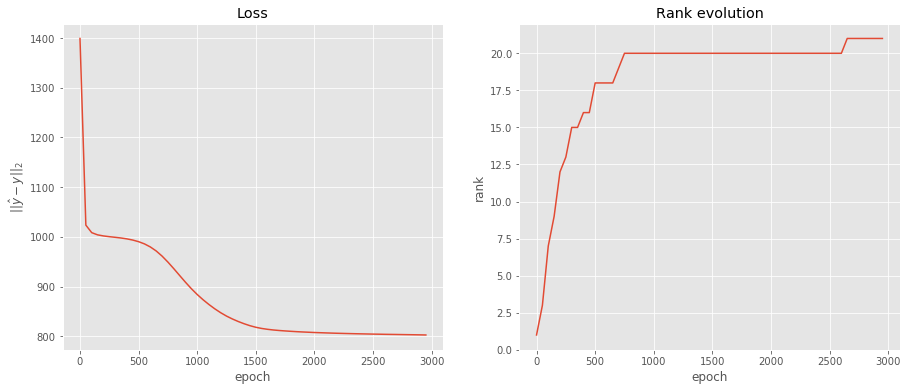

In [25]:
loss_hist_y, rank_hist_y = train_nn(net_y, opt, loader, criterion, num_epochs=3000, with_noise=False, sigma_noise=20.)

As we can see, there is no convergence of the optimization(

Now, let's consider linear network with Gaussian dropout, trained via `GD`

In [8]:
torch.manual_seed(42)
np.random.seed(42)
num_points=1000 
x_size=1000
y_size=250

data, R = make_random_affine_dependency_dataset(num_points, x_size, y_size, device=device)
net_drop = linearNN_dropout(x_size, y_size, widths=[250,], drop_alpha=0.2, init=10).to(device)
net_drop.train()

opt = torch.optim.SGD(net_drop.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loader = DataLoader(data, batch_size=num_points, drop_last=False)

Epoch: 2950


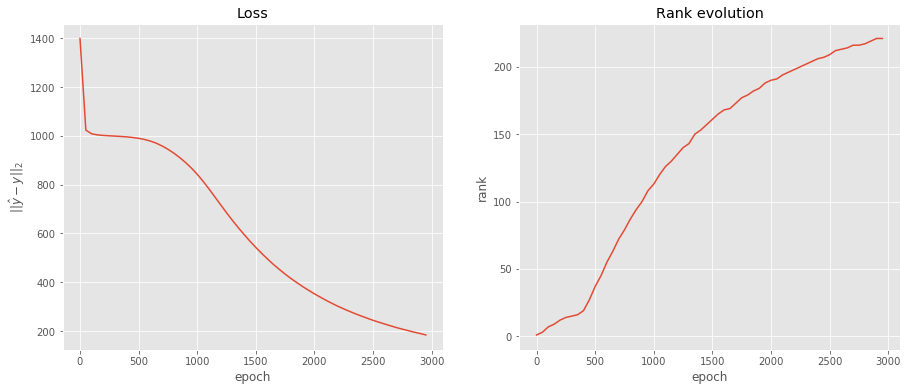

In [9]:
loss_hist_drop, rank_hist_drop = train_nn(net_drop, opt, loader, criterion, num_epochs=3000, with_noise=False, sigma_noise=20.)

Let's show comparison between `GD` and `Perturbed GD`

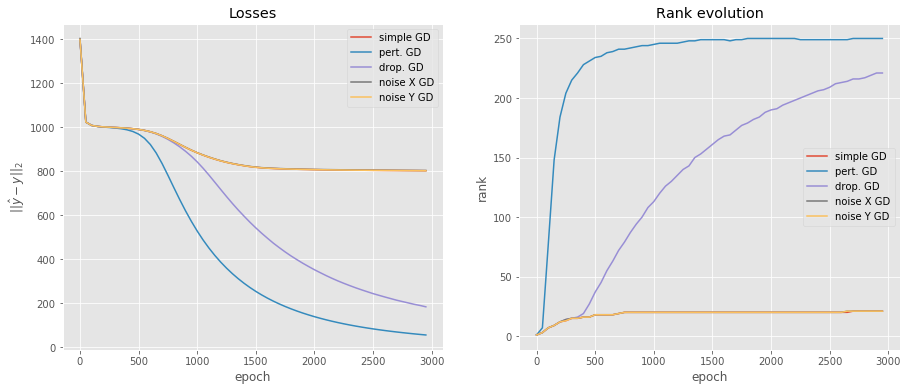

In [26]:
verbose_interval=50
plt.style.use('ggplot')
axis = range(0, verbose_interval * len(loss_hist_gd), verbose_interval)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(axis, loss_hist_gd, label='simple GD')
ax1.plot(axis, loss_hist_gd_ns, label='pert. GD')
ax1.plot(axis, loss_hist_drop, label='drop. GD')
ax1.plot(axis, loss_hist_x, label='noise X GD')
ax1.plot(axis, loss_hist_y, label='noise Y GD')
ax1.legend()
ax1.set_title('Losses')
ax1.set_xlabel('epoch')
ax1.set_ylabel('$||\hat{y} - y||_2$')

ax2.plot(axis, rank_hist_gd, label='simple GD')
ax2.plot(axis, rank_hist_gd_ns, label='pert. GD')
ax2.plot(axis, rank_hist_drop, label='drop. GD')
ax2.plot(axis, rank_hist_x, label='noise X GD')
ax2.plot(axis, rank_hist_y, label='noise Y GD')
ax2.legend()
ax2.set_title('Rank evolution')
ax2.set_xlabel('epoch')
ax2.set_ylabel('rank')
plt.show()

### Consider DNN with nonlinearities

In [66]:
torch.manual_seed(42)
np.random.seed(42)
num_points=1000 
x_size=1000
y_size=250

data, R = make_random_affine_dependency_dataset(num_points, x_size, y_size, device=device)
net = linearNN_with_activation(x_size, y_size, [250,], nn.ReLU(), init=10).to(device)

Full `GD` optimization procedure

In [67]:
net_gd = deepcopy(net)
opt = torch.optim.SGD(net_gd.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loader = DataLoader(data, batch_size=num_points, drop_last=False)

Epoch: 4950


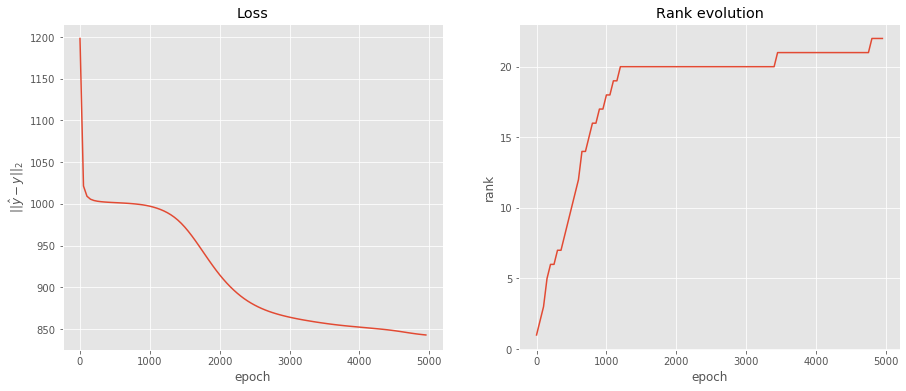

In [68]:
loss_hist_gd_rl, rank_hist_gd_rl = train_nn(net_gd, opt, loader, criterion, num_epochs=5000, with_noise=False, sigma_noise=20.)

Perturbed `GD` optimization procedure

In [69]:
net_gd_ns = deepcopy(net)
opt = torch.optim.SGD(net_gd_ns.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loader = DataLoader(data, batch_size=num_points, drop_last=False)

Epoch: 4950


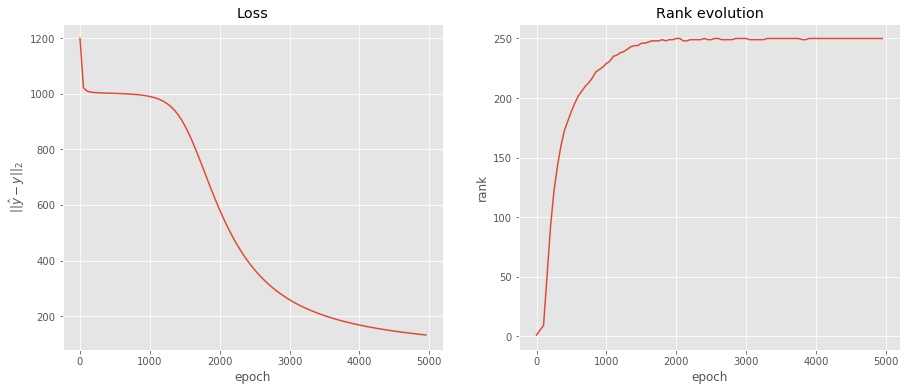

In [70]:
loss_hist_gd_ns_rl, rank_hist_gd_ns_rl = train_nn(net_gd_ns, opt, loader, criterion, num_epochs=5000, with_noise=True, sigma_noise=0.04)

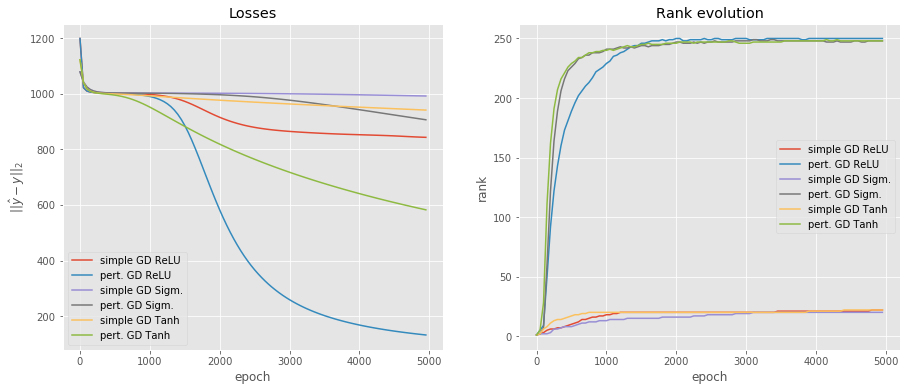

In [71]:
verbose_interval=50
plt.style.use('ggplot')
axis = range(0, verbose_interval * len(loss_hist_gd_rl), verbose_interval)
axis_sg = range(0, verbose_interval * len(loss_hist_gd_sg), verbose_interval)
axis_th = range(0, verbose_interval * len(loss_hist_gd_th), verbose_interval)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(axis, loss_hist_gd_rl, label='simple GD ReLU')
ax1.plot(axis, loss_hist_gd_ns_rl, label='pert. GD ReLU')
ax1.plot(axis_sg, loss_hist_gd_sg, label='simple GD Sigm.')
ax1.plot(axis_sg, loss_hist_gd_ns_sg, label='pert. GD Sigm.')
ax1.plot(axis_th, loss_hist_gd_th, label='simple GD Tanh')
ax1.plot(axis_th, loss_hist_gd_ns_th, label='pert. GD Tanh')
ax1.legend()
ax1.set_title('Losses')
ax1.set_xlabel('epoch')
ax1.set_ylabel('$||\hat{y} - y||_2$')

ax2.plot(axis, rank_hist_gd_rl, label='simple GD ReLU')
ax2.plot(axis, rank_hist_gd_ns_rl, label='pert. GD ReLU')
ax2.plot(axis_sg, rank_hist_gd_sg, label='simple GD Sigm.')
ax2.plot(axis_sg, rank_hist_gd_ns_sg, label='pert. GD Sigm.')
ax2.plot(axis_th, rank_hist_gd_th, label='simple GD Tanh')
ax2.plot(axis_th, rank_hist_gd_ns_th, label='pert. GD Tanh')
ax2.legend()
ax2.set_title('Rank evolution')
ax2.set_xlabel('epoch')
ax2.set_ylabel('rank')
plt.show()